In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer

In [ ]:
import shap

In [4]:
# Importing datatsets
train_df = pd.read_csv('archive/train.csv')
test_df = pd.read_csv('archive/test.csv')

/var/folders/hp/00w3l6ls0c71n_1yhq5ptylw0000gn/T/ipykernel_36975/3639023529.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('archive/train.csv')


In [5]:
train_df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [6]:
print(train_df.head())
print(test_df.head())

       ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0      19114.12            1824.843333                  3  ...           _   
1      19114.12                    NaN                  3  ...        Good   
2      19114.12                    NaN                  3  ...        Good   
3      19114.12                    NaN                  3  ...        Good   
4      19114.12            1824.843333                  3  ...        Good   

   Outstanding_Debt Credit_Utilization_Ratio     C

In [7]:
print(test_df.info())
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [5]:
# Removing irrelevent features
remove_cols = ['ID', 'Customer_ID', 'Name', 'SSN']

train_df.drop(columns=remove_cols, inplace=True)
test_df.drop(columns=remove_cols, inplace=True)

In [6]:
# Converting to the correct datatype
numerical_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
                  'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
                  'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

cat_cols = ['Type_of_Loan', 'Credit_Mix',
            'Payment_Behaviour', 'Credit_History_Age']

for col in numerical_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

In [7]:
# Imputing missing values
num_imputer = SimpleImputer(strategy='median')
train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

In [8]:
train_df.drop_duplicates(inplace=True)

In [9]:
# Removing any noticeable outliers
train_df = train_df[(train_df['Age'] > 0) & (train_df['Age'] < 100)]
train_df = train_df[(train_df[numerical_cols] > 0).all(axis=1)]


Q1 = train_df[numerical_cols].quantile(0.25)
Q3 = train_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
train_df = train_df[~((train_df[numerical_cols] < (Q1 - 1.5 * IQR)) |
                      (train_df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

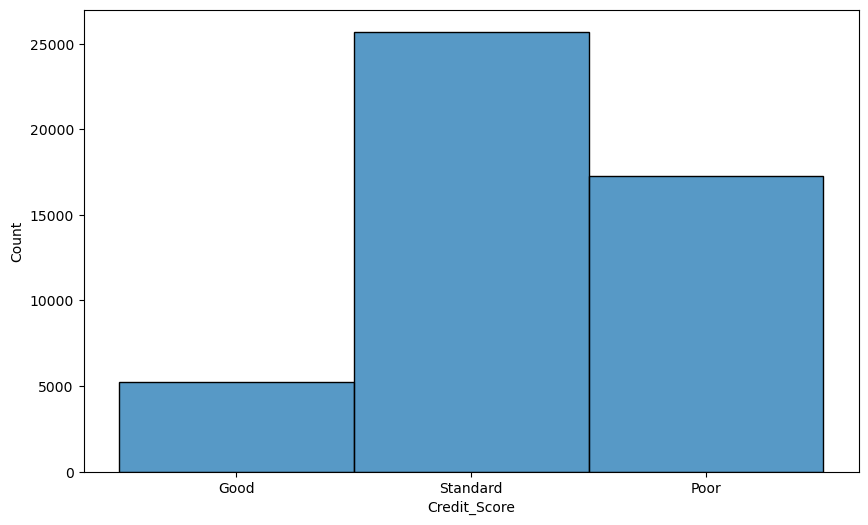

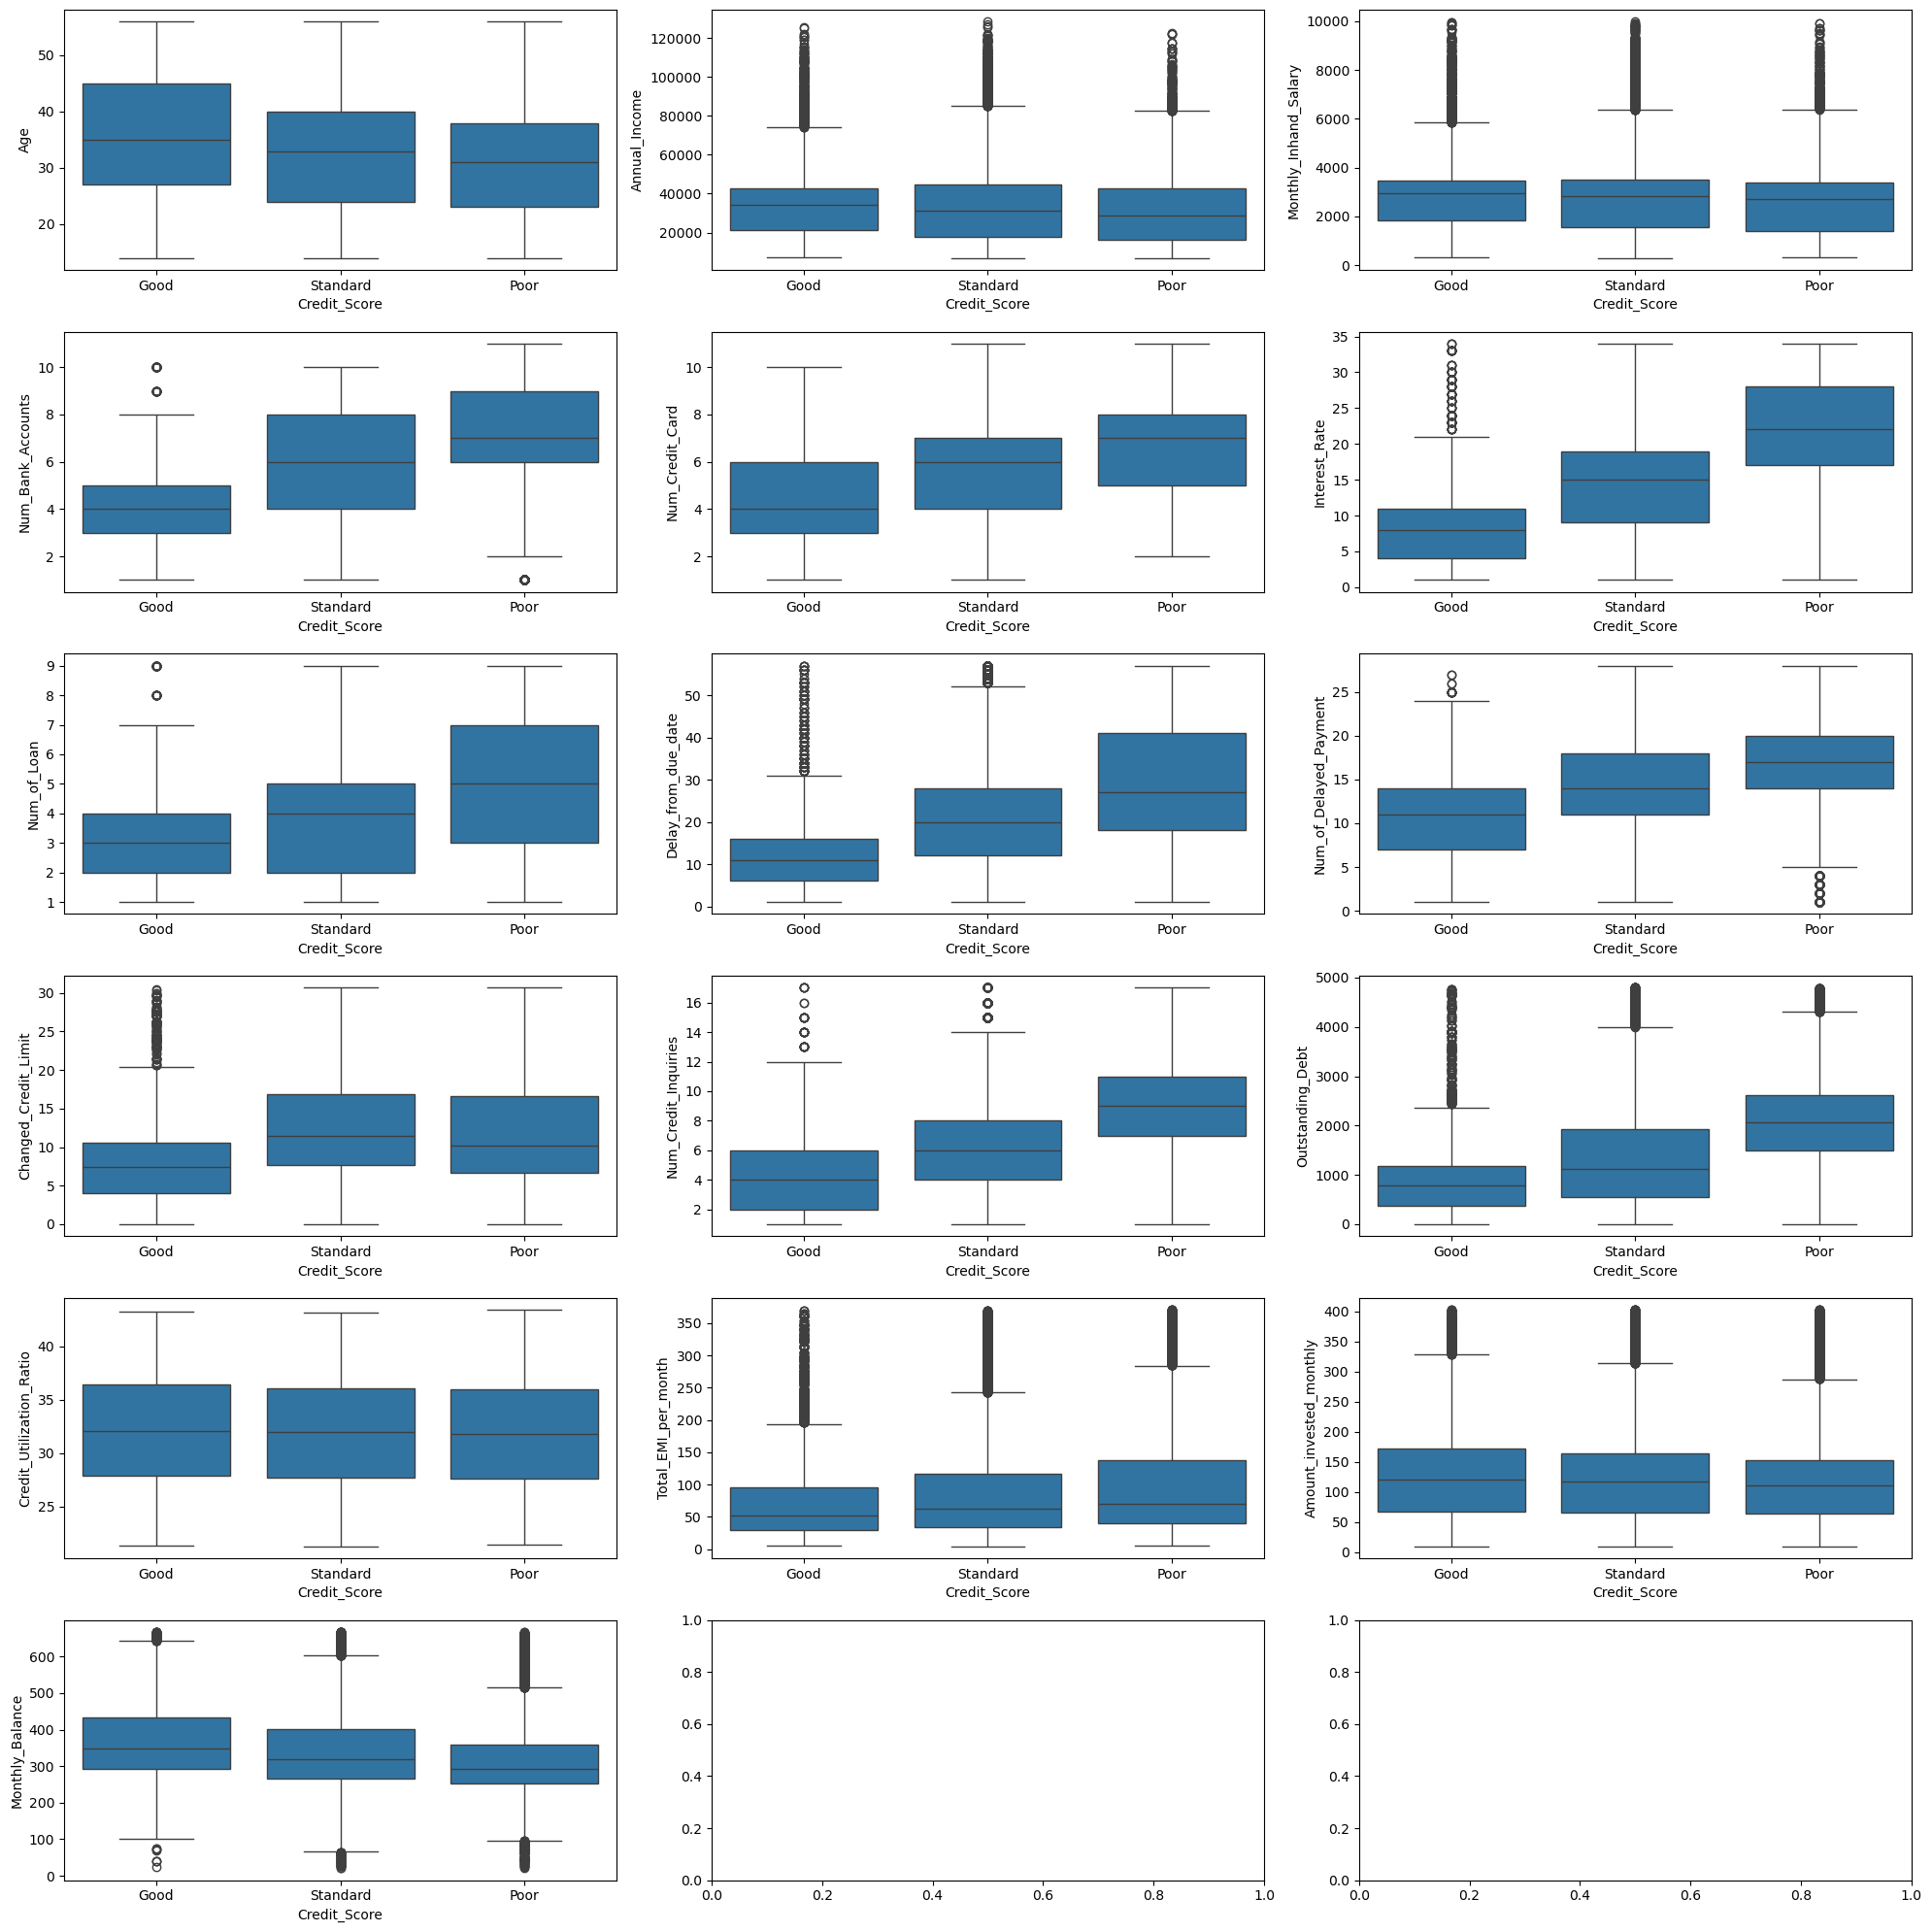

In [13]:
# Visualising data
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Credit_Score')
plt.show()

fig, ax = plt.subplots(6, 3, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=train_df, x='Credit_Score', y=col, ax=ax[i])

plt.tight_layout()
plt.show()

In [14]:
train_df.to_pickle('credit_score_df.csv')

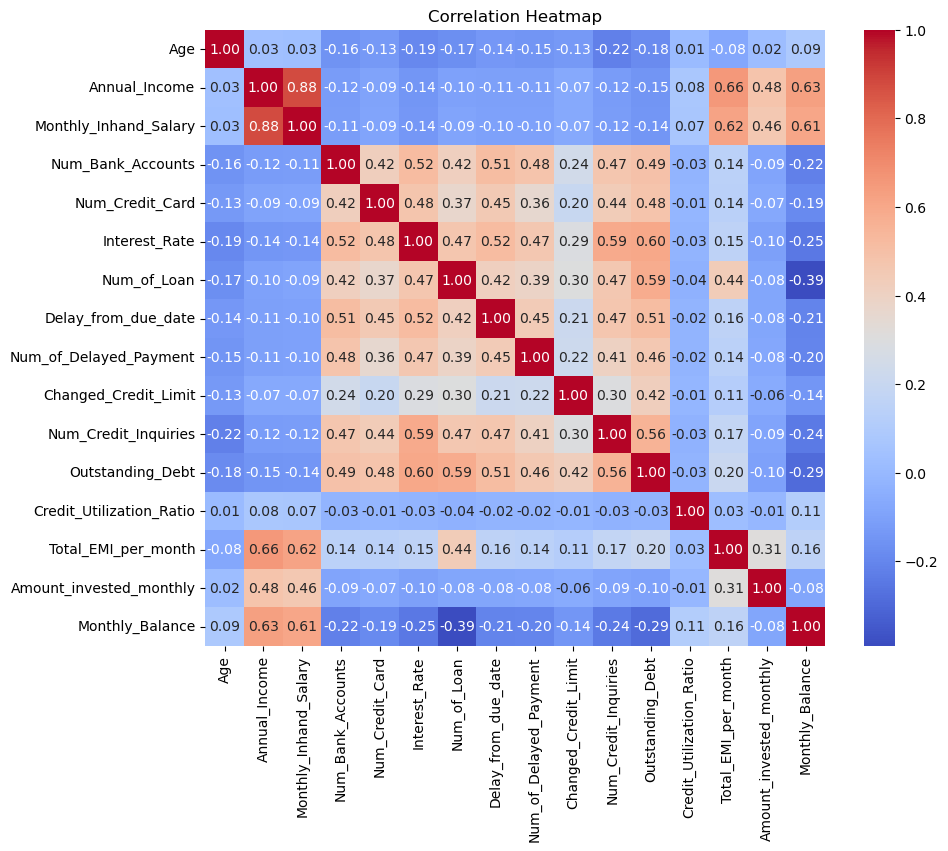

In [15]:
numeric_df = train_df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

In [10]:
# Train-test split
X = train_df.iloc[:, :-1]
X = X[numerical_cols]
y = train_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [11]:
# Scaling training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(
    X_train, columns=numerical_cols)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(
    X_test, columns=numerical_cols)

In [19]:
# Logistic regression model
lrc = LogisticRegression(max_iter=400, random_state=42,
                         class_weight='balanced')
lrc.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=400, random_state=42)

In [20]:
lrc_pred = lrc.predict(X_test)

In [21]:
lrc_cvs = cross_val_score(lrc, X_train, y_train).round(2).mean()
lrc_acc = accuracy_score(y_test, lrc_pred)

print(lrc_cvs)
print(lrc_acc)

0.6
0.599128540305011


In [22]:
# Random Forest model
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
rfc_pred = rfc.predict(X_test)

In [24]:
rfc_cvs = cross_val_score(rfc, X_train, y_train).round(2).mean()
rfc_acc = accuracy_score(y_test, rfc_pred)

print(rfc_cvs)
print(rfc_acc)

0.7860000000000001
0.7934433032472248


In [25]:
# Multi-layer perceptron model
mlp = MLPClassifier(hidden_layer_sizes=(10, 5, 3), solver='lbfgs')
mlp.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=(10, 5, 3), solver='lbfgs')

In [26]:
mlp_pred = mlp.predict(X_test)

In [27]:
mlp_cvs = cross_val_score(mlp, X_train, y_train).round(2).mean()
mlp_acc = accuracy_score(y_test, mlp_pred)

print(mlp_cvs)
print(mlp_acc)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

0.706
0.6930179479199087


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [28]:
mlp_v2 = MLPClassifier((20, 10, 10, 3), learning_rate='adaptive',
                       max_iter=500, solver='adam', alpha=0.001)

mlp_v2.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(20, 10, 10, 3),
              learning_rate='adaptive', max_iter=500)

In [29]:
mlp_v2_pred = mlp_v2.predict(X_test)

In [30]:
mlp_v2_cvs = cross_val_score(mlp_v2, X_train, y_train).round(2).mean()
mlp_v2_acc = accuracy_score(y_test, mlp_v2_pred)

In [31]:
print(mlp_v2_cvs)
print(mlp_v2_acc)

0.712
0.7192654839713664


(0.5, 0.85)

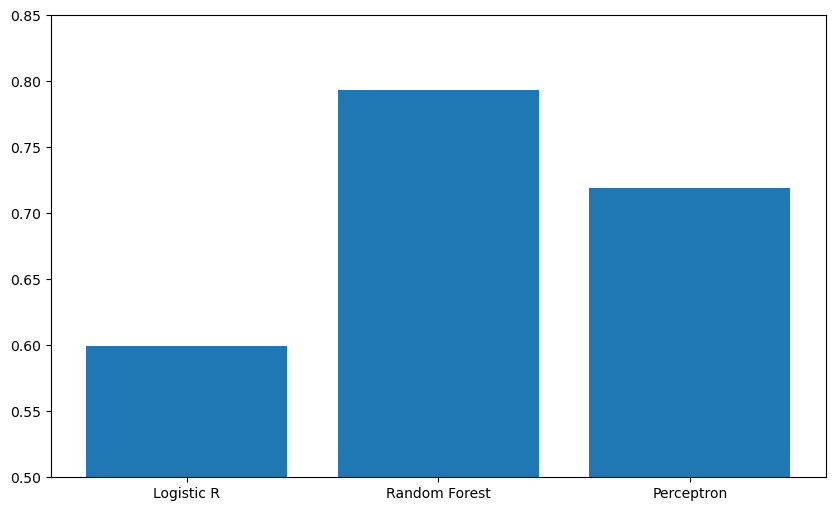

In [32]:
comparisons = pd.DataFrame({'Logistic R': [lrc_acc], 'Random Forest': [
                           rfc_acc], 'Perceptron': [mlp_v2_acc]})
plt.figure(figsize=(10, 6))

plt.bar(comparisons.columns, comparisons.iloc[0])
plt.ylim(0.5, 0.85)

In [33]:
estimators = []
accuracies = []

for i in range(50, 500, 50):
    rfc_v2 = RandomForestClassifier(
        n_estimators=i, random_state=42, criterion='entropy', class_weight='balanced')
    rfc_v2.fit(X_train, y_train)

    pred = rfc_v2.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    estimators.append(i)

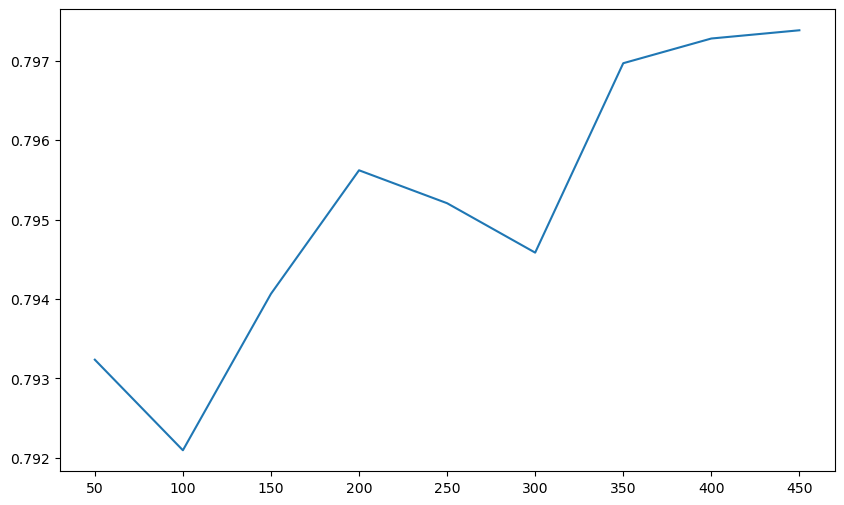

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(estimators, accuracies)

plt.show()

In [12]:
rfc_v2 = RandomForestClassifier(
    n_estimators=450, random_state=42, criterion='entropy', class_weight='balanced')
rfc_v2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=450, random_state=42)

In [14]:
explainer = shap.TreeExplainer(rfc_v2)

In [ ]:
explainer = shap.TreeExplainer(rfc_v2)

shap_values = explainer.shap_values(X_test, approximate=True)

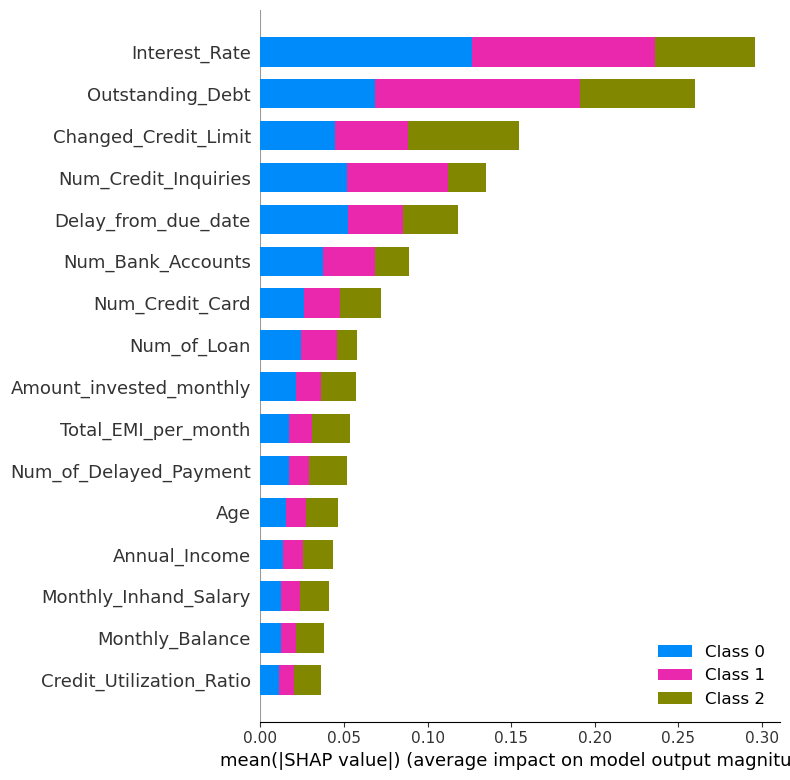

In [ ]:

# Plot summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar",
                  feature_names=X_test.columns)